# Waveform response calculation
Supposing we have different energy deposit points in one event, therefore, different drift electron clusters. 
Each cluster is supposed to have some "waveform response" on strips.
The waveform response on one single strip is supposed to be a combination of all these 'waveform responses'. 
Still, we need to consider other effects like,
- electron diffusion during drift (both x-y plane and z direction);
- convolved with the electronics response function in offline;

In [4]:

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (8,6)

In [5]:
from toy_digitization import digitization

digi = digitization(SamplingFrequency=2)

Text(0.5, 0, 'Time [us]')

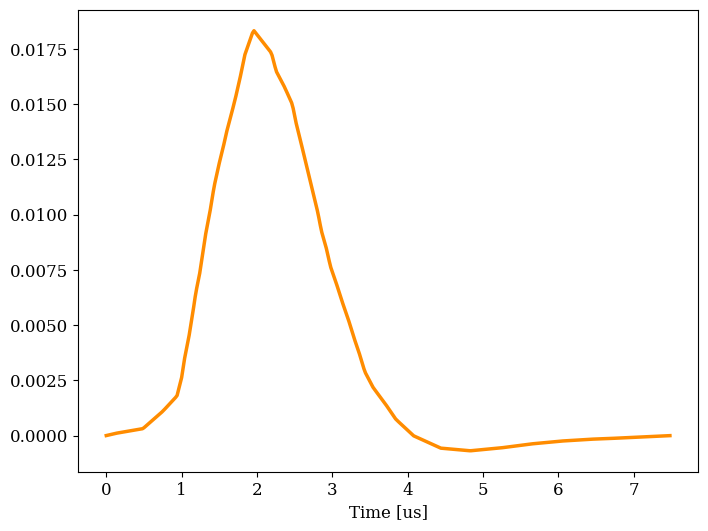

In [6]:
digi.load_asic_response()

import numpy as np
plt.plot(np.arange(len(digi.asic_response_amp))*0.02, digi.asic_response_amp, lw=2.5, color='darkorange')
plt.xlabel('Time [us]')

## Adding noise
Randomly sample noises from the pre-produced noise lib file and add to the waveform.

In [7]:
from toy_digitization import digitization
digi = digitization(SamplingFrequency=2.)
digi.load_asic_noise()


KeyboardInterrupt: 

/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


(0.0, 100.0)

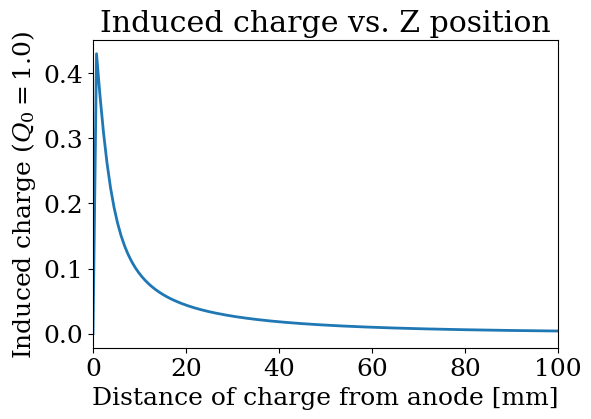

In [ ]:
# generate a collection signal on a single strip:

from SignalCalculator import SignalCalculator

n_zsteps = 400

pt = (0., 0., 300) # unit: mm
pt_z_steps = np.linspace(0, pt[2], n_zsteps)
pt_charge_vs_z = np.zeros(n_zsteps)

for i in range(n_zsteps):
    pt_charge_vs_z[i] = SignalCalculator.InducedChargeNEXOStrip(1.,\
                                                                pt[0], pt[1],\
                                                                pt_z_steps[i],
                                                                padSize=6.0)
    
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(pt_z_steps, pt_charge_vs_z, '-', lw=2)
ax.set_title('Induced charge vs. Z position')
ax.set_xlabel('Distance of charge from anode [mm]')
ax.set_ylabel(r'Induced charge ($Q_0=1.0$)')
ax.set_xlim(0, 100)


/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


Text(0, 0.5, 'Measured charge signal ($Q_0=1.0$)')

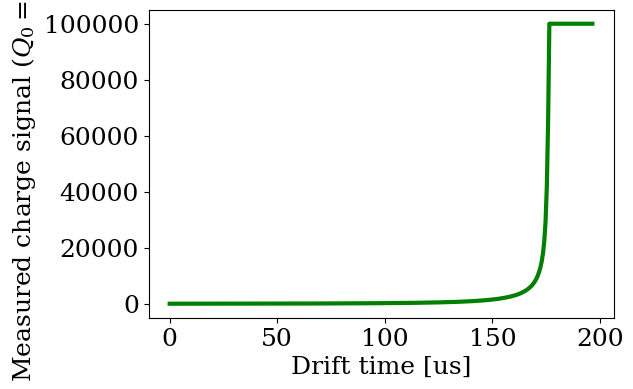

In [ ]:
from SignalCalculator import SignalCalculator

Q = 1e5
pt = (3, 0, 300) # unit: mm

pt_drift_points, pt_charge_wfm = SignalCalculator.ComputeChargeWaveformOnStripWithIons( \
                                                                                        Q, pt[0], pt[1], pt[2], \
                                                                                        padSize=6.0, numPads=16 )

#pt_drift_points = np.append(pt_drift_points, 200.)
#pt_charge_wfm   = np.append(pt_charge_wfm, pt_charge_wfm[-1])


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(pt_drift_points, pt_charge_wfm, '-', lw=3, color='green')
ax.set_xlabel('Drift time [us]')
ax.set_ylabel(r'Measured charge signal ($Q_0=1.0$)')

In [ ]:
digi.convolve_asic_response(pt_drift_points, pt_charge_wfm)

digi.generate_noise(waveformSize=len(digi.cryoAmp))

outputWF, fTruth = digi.quantization(digi.cryoAmp, digi.asic_noise_amp, 40000.0);

------- Debug output: Noise sum: 2768.5390625


Text(0, 0.5, 'adc')

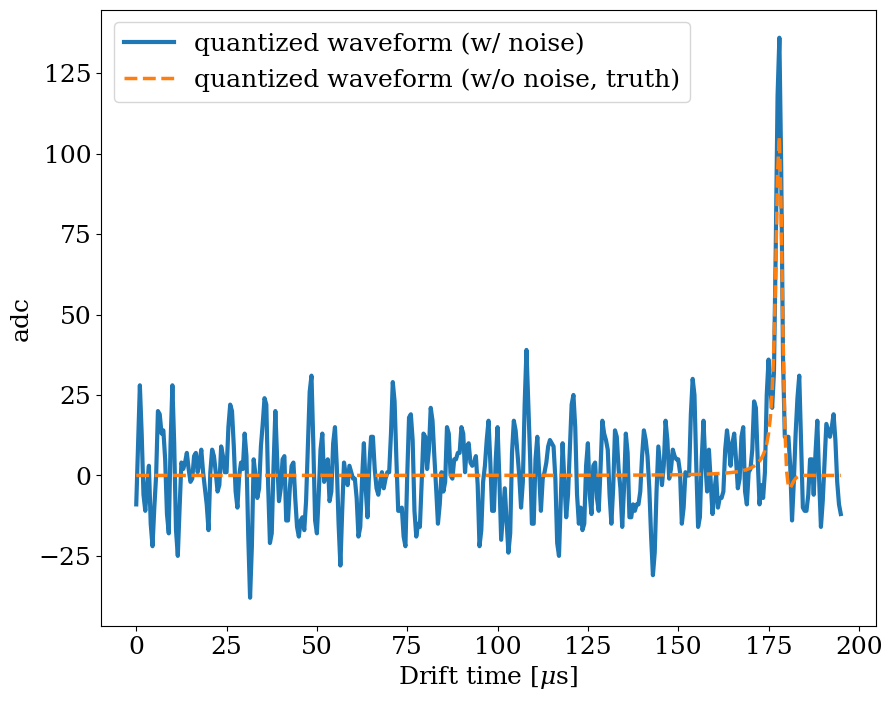

In [ ]:
fig, ax = plt.subplots()

ax.plot(digi.cryoTime, outputWF, '-', lw=3, label='quantized waveform (w/ noise)',)
ax.plot(digi.cryoTime, fTruth, '--', lw=2.5, label='quantized waveform (w/o noise, truth)')

ax.legend()
ax.set_xlabel(r'Drift time [$\mu$s]')
ax.set_ylabel('adc')


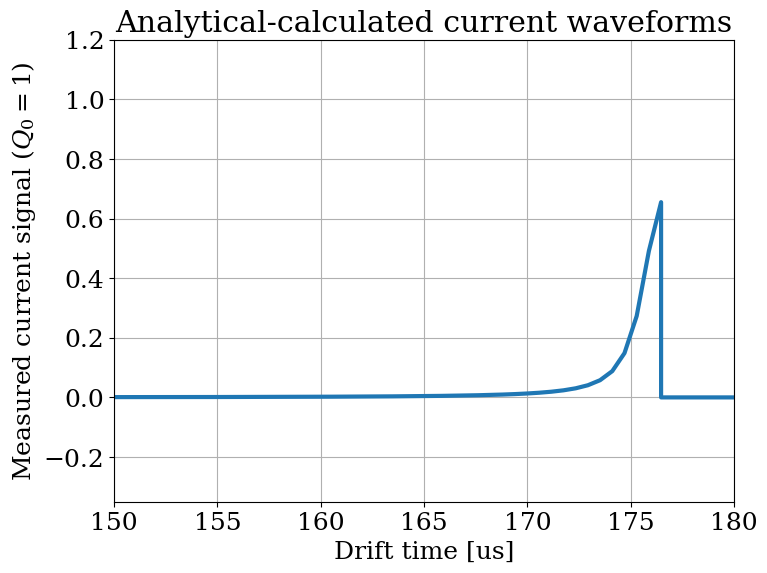

In [ ]:
# Calculate the current signal by differentiation 

import matplotlib.pyplot as plt

Q = 1.0
pt = (3., 0., 300) # unit: mm

pt_drift_points_cur, pt_current_wfm = SignalCalculator.ComputeCurrentWaveformOnStrip(Q, pt[0], pt[1], pt[2], padSize=6.0, numPads=16)

fig, ax = plt.subplots(figsize=(8, 6))
pt_drift_points_cur = np.append(pt_drift_points_cur, pt_drift_points_cur[-1])
pt_drift_points_cur = np.append(pt_drift_points_cur, 200.)
pt_current_wfm = np.append(pt_current_wfm, [0., 0.])

ax.plot(pt_drift_points_cur, pt_current_wfm, '-', lw=3)
ax.set_xlabel('Drift time [us]')
ax.set_ylabel(r'Measured current signal ($Q_0=1$)')
ax.set_title('Analytical-calculated current waveforms')
ax.set_xlim(150., 180.)
ax.set_ylim(-0.35, 1.2)
ax.grid(True)

## Waveform generation in nEXO offline
Induced current waveform is not generated uniformly on the time axis. The sampling sequence on z-axis is determined by `nEXOChargeReadoutDigitize::DetermineSamplingSequence`. (The basic principle is smaller interval as electrons approching the cathode.) These are called 'preSamplingWF'.

Do-sampling with `nEXODigiAnalysis::CRYO_50MHz`.



In [ ]:
preSampleTime = pt_drift_points
preSampleAmp  = pt_charge_wfm

digi.convolve_asic_response(preSampleTime, preSampleAmp)

## Waveform summing up
Try to consider ET clusters at different times and positions.

In [ ]:
from TEclusters import processor

proc = processor()

In [ ]:
# dummy combination of 3 TE clusters and display

import numpy as np

v = 1.7

## configure positions, times and charges here
##############################
x = [3, 0, 2]
y = [0, 2, 1]
z = [600, 500, 300]
dt1 = (z[0] - z[1]) / v
dt2 = (z[0] - z[2]) / v
dt = [0, dt1, dt2]
qs = [2e5, 1.5e5, 1e5]
##############################

amps = []

for i in range(2):
    positions, times, charges = [], [], []
    positions.append((x[i], y[i], z[i]))
    times.append(dt[i])
    charges.append(qs[i])
    amp = proc.dummy_combination(positions, times, charges)
    amps.append(amp)


positions, times, charges = [], [], []
for i in range(2):
    positions.append((x[i], y[i], z[i]))
    times.append(dt[i])
    charges.append(1e5)


amp_summed = proc.dummy_combination(positions, times, charges)


/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


Text(0.5, 1.0, 'Summed waveform from 3 TE clusters')

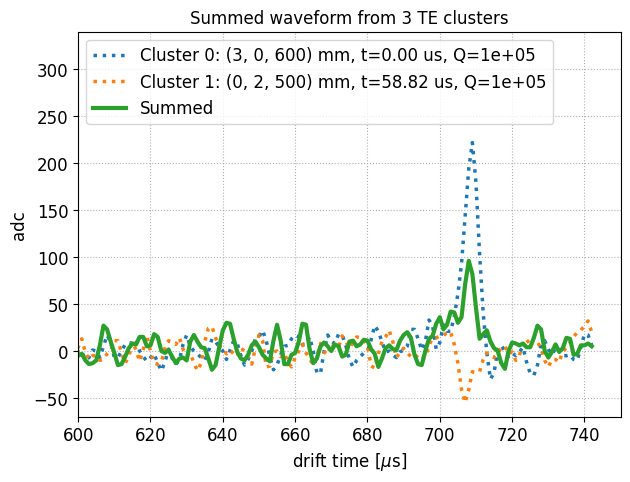

In [ ]:

### Display separately
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
for i, amp in enumerate(amps):
    ax.plot(amp, ':', lw=2.5, label=f'Cluster {i}: ({positions[i][0]}, {positions[i][1]}, {positions[i][2]}) mm, t={times[i]:.2f} us, Q={charges[i]:.0e}')
ax.plot(amp_summed, lw=3, label='Summed')
ax.set_xlim(600, 750)
ax.set_xlabel(r'drift time [$\mu$s]', size=12)
ax.set_ylabel('adc', size=12)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, linestyle=':')
ax.set_ylim(-70, 340)
ax.legend(loc='upper left', prop={"size": 12})
ax.set_title('Summed waveform from 3 TE clusters', size=12)

## Dummy waveform fitting
The baisc idea for this dummy fitting is that we know the exact number of TE clusters contributing on the waveform (in this case, 2 clusters). 

- For each cluster, we want to fit parameters $x, y, z, t$ and $Q$;
- Each independent waveform is analytically calculated from Brian's codes, using $x, y, z, Q$, and convolving with the ASIC response (this is the simulation flow);
- Time $t$ is used to shift the start point of each waveform;

The fitting seems impossible. As we only consider two clusters and fix all position and time variables, only fit two charge quantities. It takes very long time (wait for 8 min not finished)...

Only when we fix all positions and times, in which case the shapes of convolved waveform will not change and only the amplitude will. By fitting 


In [ ]:
from waveform_fit import fitter
fitter = fitter(SamplingFrequency=2.0)

In [ ]:
%time
data_y = amp_summed
data_x = np.arange(len(data_y)) * 0.5
m = fitter.dummy_fixed_fitting(data_x, data_y, [dt[0], x[0], y[0], z[0], qs[0], dt[1], x[1], y[1], z[1], qs[1]])


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
Total fitting time consumed: 0.3217778205871582.


In [ ]:
print(m.values)
print(m.covariance)
print(m.fmin)

<ValueView q0=11156.694136017195 q1=10917.650390261946>
┌────┬───────────────────┐
│    │       q0       q1 │
├────┼───────────────────┤
│ q0 │  4.5e+04   0.09e6 │
│ q1 │   0.09e6 4.35e+05 │
└────┴───────────────────┘
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.236e+04 (χ²/ndof = 16.7) │              Nfcn = 195              │
│ EDM = 6.31e-06 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok

/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


Text(0.5, 1.0, 'Summed waveform from 3 TE clusters')

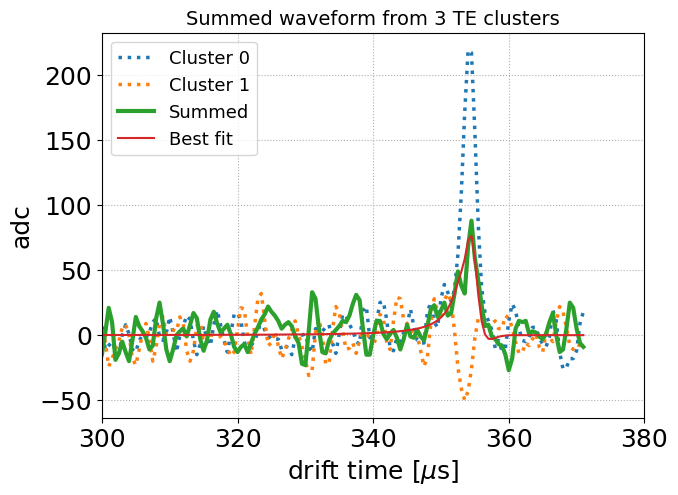

In [ ]:
## Display separately
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
for i, amp in enumerate(amps):
    ax.plot(np.arange(len(amp))*0.5, amp, ':', lw=2.5, label=f'Cluster {i}')

tt = np.arange(len(amp_summed)) * 0.5
ax.plot(tt, amp_summed, lw=3, label='Summed')

ax.plot(tt, fitter.dummy_fixed_model(tt, [dt[0], x[0], y[0], z[0], m.values[0], dt[1], x[1], y[1], z[1], m.values[1]]), label='Best fit')

ax.set_xlim(300, 380)
ax.set_xlabel(r'drift time [$\mu$s]')
ax.set_ylabel('adc')
ax.grid(True, linestyle=':')
ax.legend(loc='upper left', fontsize=13)
ax.set_title('Summed waveform from 3 TE clusters', fontsize=14)

### Grouping PDFs fitting
What if we construct waveform templates with cluster locating at different positions in advance?

#### Pre-producing PDFs
- For induction channel, we choose a range $x\in[-48, 48]$ mm and $y\in [-30, 30]$ mm (both have step length as 6 mm), and z fixed as 100 mm.
- For collection channel, we fixe x=3 mm, y=0 mm, z = 100mm.

In [ ]:
# Generate grid PDFs and save them into h5 files.

from tqdm.notebook import tqdm
import numpy as np
from SignalCalculator import SignalCalculator
from toy_digitization import digitization

digi = digitization(SamplingFrequency=2.0)

X = np.arange(-48, 48+6, 6)
Y = np.arange(-30, 30+6, 6)
z = 100 
q = 1e5
induction_pdfs = {}
for x in tqdm(X):
    for y in Y:
        pdf_name = f'x{x}y{y}'
        tt, wf = SignalCalculator.ComputeChargeWaveformOnStripWithIons(q, x, y, z)
        digi.convolve_asic_response(tt, wf)
        digi.generate_noise(len(digi.cryoAmp))
        digi.quantization(digi.cryoAmp, digi.asic_noise_amp, 40000.)
        pdf = digi.get_quantized_truthWF()
        induction_pdfs[pdf_name] = pdf

collection_pdf = {}
x, y = 3, 0
tt, wf = SignalCalculator.ComputeChargeWaveformOnStripWithIons(q, x, y, z)
digi.convolve_asic_response(tt, wf)
digi.generate_noise(len(digi.cryoAmp))
digi.quantization(digi.cryoAmp, digi.asic_noise_amp, 40000.)
pdf = digi.get_quantized_truthWF()
pdf_name = 'coll'
collection_pdf[pdf_name] = pdf

import h5py

with h5py.File('gridPDFs_induction_test.h5', 'w') as f:
    for name, pdf in induction_pdfs.items():
        f.create_dataset(name, data=pdf)

with h5py.File('gridPDFs_collection_test.h5', 'w') as f:
    for name, pdf in collection_pdf.items():
        f.create_dataset(name, data=pdf)


  0%|          | 0/17 [00:00<?, ?it/s]

/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


### Load fitter for fitting procedures

In [14]:
from importlib import reload
import waveform_fit

reload(waveform_fit)
from waveform_fit import fitter

fitter = fitter(SamplingFrequency=2)

# Load the pre-produced grid PDFs:
fitter.load_gridPDFs()

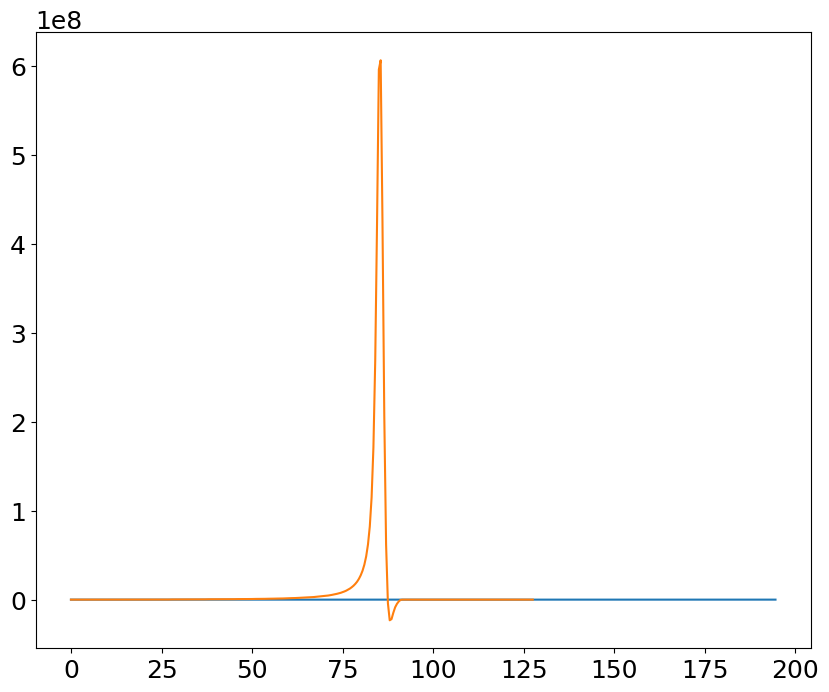

In [ ]:
# Producing a channel w/ only one collection TE cluster:
from TEclusters import processor
proc = processor()

x_c, y_c, z_c, q_c, t_c = 3., 0., 300., 1e5, 0
amp_c = proc.dummy_combination([(x_c, y_c, z_c)], [t_c], [q_c])

import matplotlib.pyplot as plt
plt.plot(np.arange(len(amp_c))*0.5, amp_c)

plt.plot(fitter.gridPDFs_time, fitter.gridPDFs_collection['coll']*1e5)


In [ ]:
data_y = amp_c
data_x = np.arange(len(data_y)) * 0.5
data_x = data_x[-100::]
data_y = data_y[-100::]

m = fitter.dummy_oneCollectionWF_fitting(data_x, data_y, [0., 300., 1])

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.0119534 Requested 0.0002
W VariableMetricBuilder No improvement in line search


Text(132, 3000, 'q0=1.0e+05, q$_{fit}$=1.0e+05$\\pm$1.44e+02')

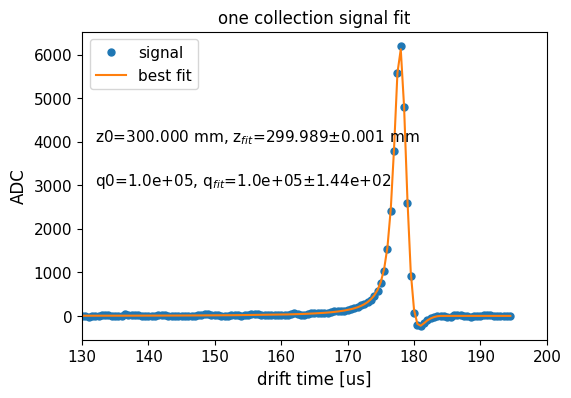

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(len(amp_c))*0.5, amp_c, 'o', ms=5, label='signal')
dt = m.values['z0']/1.70 - 100/1.70 + m.values['t0']
plt.plot(np.arange(len(amp_c))*0.5, np.interp(np.arange(len(amp_c))*0.5+25-dt, fitter.gridPDFs_time, fitter.gridPDFs_collection['coll'])*m.values['q0'], label='best fit')

ax.set_xlabel('drift time [us]', fontsize=12)
ax.set_ylabel('ADC', fontsize=12)
ax.legend(prop={'size':11}, loc='upper left')
ax.tick_params(axis='both', labelsize=11)
ax.set_xlim(130, 200)
ax.set_title('one collection signal fit', fontsize=12)

ax.text(132, 4000, f'z0={z_c:.3f} mm, '+r'z$_{fit}$' +f'={m.values['z0']:.3f}' + r'$\pm$' + f'{m.errors['z0']:.3f} mm', fontsize=11)
ax.text(132, 3000, f'q0={q_c:.1e}, '+r'q$_{fit}$' +f'={m.values['q0']*1e5:.1e}' + r'$\pm$' + f'{m.errors['q0']*1e5:.2e}', fontsize=11)


/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


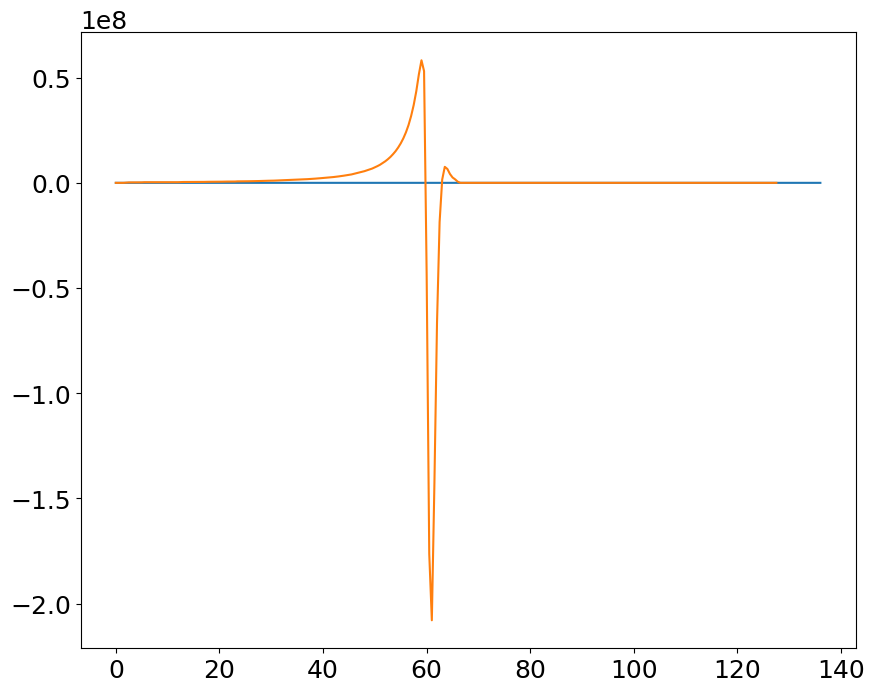

In [ ]:
# Producing a channel w/ only one collection TE cluster:
from TEclusters import processor
proc = processor()

x_i, y_i, z_i, q_i, t_i = 3., 3., 200., 1e5, 0
amp_i = proc.dummy_combination([(x_i, y_i, z_i)], [t_i], [q_i])

import matplotlib.pyplot as plt
plt.plot(np.arange(len(amp_i))*0.5, amp_i)

plt.plot(fitter.gridPDFs_time, np.interp(fitter.gridPDFs_time+25, fitter.gridPDFs_time, fitter.PDF_interpolation(x_i, y_i)*q_i))

In [ ]:
data_y = amp_i
data_x = np.arange(len(data_y)) * 0.5
data_x = data_x[-100::]
data_y = data_y[-100::]

m = fitter.dummy_oneInductionWF_fitting(data_x, data_y, [t_i, x_i, y_i, z_i, q_i])

print(m)

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W DavidonErrorUpdator gvg <= 0 : cannot update - return same matrix
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -2.34936
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.000124874
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -14519
W MnPosDef Added to diagonal of Error matrix a value 14519.5
W MnPosDef Matrix forced pos-def by adding to diagonal 6.27943
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 2.99988e+13 Requested 0.0002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 74.7989 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is inv

2.7980531109368774


Text(0.5, 1.0, 'one induction signal fit')

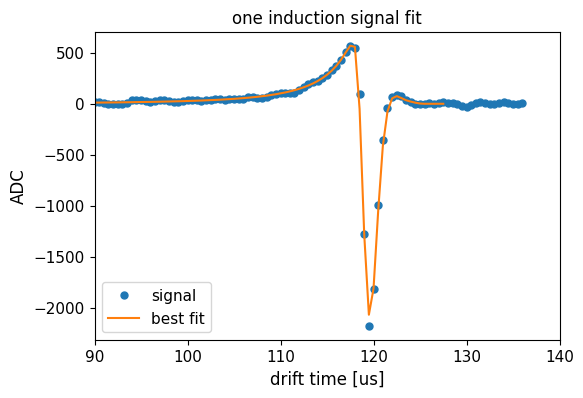

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(len(amp_i))*0.5, amp_i, 'o', ms=5, label='signal')
dt = m.values['z0']/1.70 - 100/1.70 + m.values['t0']
print(m.values['y0'])
plt.plot(fitter.gridPDFs_time, np.interp(fitter.gridPDFs_time+25-dt, fitter.gridPDFs_time, fitter.PDF_interpolation( m.values['x0'], m.values['y0'])*m.values['q0']), label='best fit')

ax.set_xlabel('drift time [us]', fontsize=12)
ax.set_ylabel('ADC', fontsize=12)
ax.legend(prop={'size':11}, loc='lower left')
ax.tick_params(axis='both', labelsize=11)
ax.set_xlim(90, 140)
ax.set_title('one induction signal fit', fontsize=12)

In [ ]:
#### Generate collection waveforms from two clusters
import numpy as np

from TEclusters import processor
proc = processor()

x_c0, y_c0, z_c0, q_c0, t_c0 = 3., 0., 300., 1e5, 0
x_c1, y_c1, z_c1, q_c1, t_c1 = 10., 0., 295., 2e5, 0
amp_c = proc.dummy_combination([(x_c0, y_c0, z_c0), (x_c1, y_c1, z_c1)], [t_c0, t_c1], [q_c0, q_c1])



In [ ]:
from importlib import reload
import waveform_fit

reload(waveform_fit)
from waveform_fit import fitter

fitter = fitter(SamplingFrequency=2)

# Load the pre-produced grid PDFs:
fitter.load_gridPDFs()

data_y = amp_c
data_x = np.arange(len(data_y)) * 0.5
data_x = data_x[-100::]
data_y = data_y[-100::]

m = fitter.dummy_twoCollectionWF_fitting(data_x, data_y, [300., 1, 295, 2])

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00302244 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00401069 Requested 0.0002
W VariableMetricBuilder No convergence; Edm 0.00401069 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00401069 Requested 0.0002
W VariableMetricBuilder No convergence; Edm 0.00401069 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00401069 Requested 0.0002
W VariableMetricBuilder No convergence; Edm 0.00401069 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish 

Text(132, 10000, 'q0=2.0e+05, q1$_{fit}$=2.06e+04$\\pm$3.96e+01')

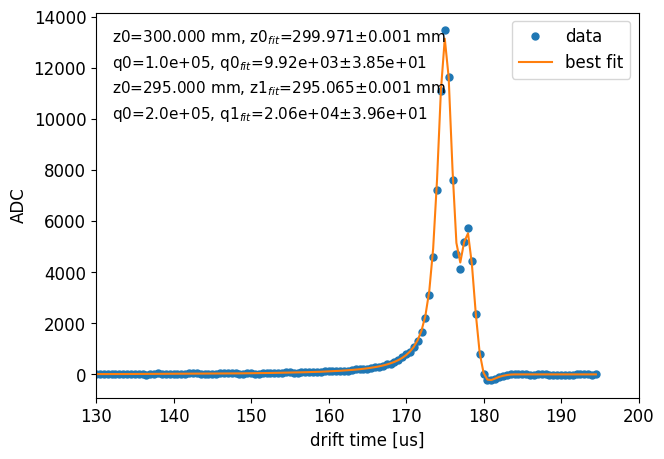

In [ ]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 5))
time = np.arange(len(amp_c))*0.5
ax.plot(time, amp_c, 'o', ms=5, label='data')

z0_fit, q0_fit, z1_fit, q1_fit = m.values['z0'], m.values['q0'], m.values['z1'], m.values['q1']

dt0 = z0_fit/1.70 - 100/1.70 - 25
dt1 = z1_fit/1.70 - 100/1.70 - 25
ax.plot(time, np.interp(time-dt0, fitter.gridPDFs_time, fitter.gridPDFs_collection['coll']*q0_fit) + np.interp(time-dt1, fitter.gridPDFs_time, fitter.gridPDFs_collection['coll']*q1_fit), label='best fit')

ax.set_xlabel('drift time [us]', fontsize=12)
ax.set_ylabel('ADC', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlim(130, 200)
ax.legend(prop={'size':12})


ax.text(132, 13000, f'z0={z_c0:.3f} mm, '+r'z0$_{fit}$' +f'={m.values['z0']:.3f}' + r'$\pm$' + f'{m.errors['z0']:.3f} mm', fontsize=11)
ax.text(132, 12000, f'q0={q_c0:.1e}, '+r'q0$_{fit}$' +f'={m.values['q0']*10000:.2e}' + r'$\pm$' + f'{m.errors['q0']*1e5:.2e}', fontsize=11)
ax.text(132, 11000, f'z0={z_c1:.3f} mm, '+r'z1$_{fit}$' +f'={m.values['z1']:.3f}' + r'$\pm$' + f'{m.errors['z1']:.3f} mm', fontsize=11)
ax.text(132, 10000, f'q0={q_c1:.1e}, '+r'q1$_{fit}$' +f'={m.values['q1']*10000:.2e}' + r'$\pm$' + f'{m.errors['q1']*1e5:.2e}', fontsize=11)


In [ ]:
# generate 1000 one-cluster collection waveforms and store into h5 file.
#### Generate collection waveforms from two clusters
import numpy as np
from tqdm.notebook import tqdm

from TEclusters import processor
proc = processor()

x_c0, y_c0, z_c0, q_c0, t_c0 = 3., 0., 200., 1e5, 0
amp_c_sets = []
for i in tqdm(range(1000)):
    amp_c = proc.dummy_combination([(x_c0, y_c0, z_c0)], [t_c0], [q_c0])
    amp_c_sets.append(amp_c)

import h5py
with h5py.File('collection_waveforms_2.h5', 'w') as f:
    for i in range(1000):
        name = f'waveform_{i}'
        f.create_dataset(name, data=amp_c_sets[i])




  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


In [ ]:
import h5py
from tqdm.notebook import tqdm
import numpy as np
z_fit = []
q_fit = []
fit_examples = []
with h5py.File('./collection_waveforms_2.h5', 'r') as f:
    for dset_name in tqdm(f.keys()):
        wf = f[dset_name]
        wf_copy = []
        for i in wf:
            wf_copy.append(i)
        time = np.arange(len(wf)) * 0.5

        m = fitter.dummy_oneCollectionWF_fitting(time, wf, [0, 200, 1])
        z0, q0 = m.values['z0'], m.values['q0']
        z_fit.append(z0)
        q_fit.append(q0)

        if dset_name == 'waveform_112' :
            fit_examples.append(time)
            fit_examples.append(wf_copy)
            fit_examples.append([0, z0, q0])


#with h5py.File('./collection_waveforms_2.h5', 'r') as f:
#    for dset_name in tqdm(f.keys()):
#        wf = f[dset_name]
#        time = np.arange(len(wf)) * 0.5
#
#        m = fitter.dummy_oneCollectionWF_fitting(time, wf, [0, 300, 1])
#        z0, q0 = m.values['z0'], m.values['q0']
#        z_fit.append(z0)
#        q_fit.append(q0)


  0%|          | 0/1000 [00:00<?, ?it/s]

W MnPosDef Matrix forced pos-def by adding to diagonal 0.0046987
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00426992
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00341254
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00341254


1.007154681051927


/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


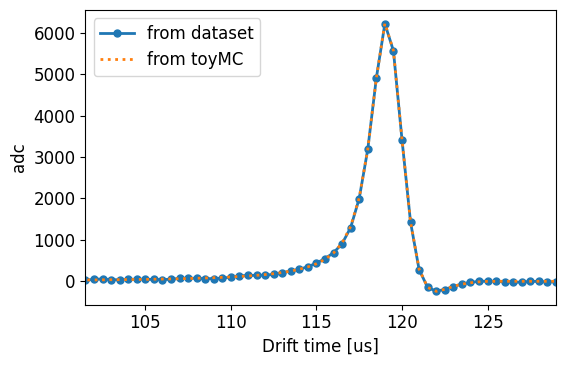

In [ ]:
print(q_fit[13])

from toyMC_loader import toyMC_loader
toyMCloader = toyMC_loader()
toyMCloader.toyMC_filename = '/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/collection_waveforms_2.h5'
toyMCloader.display_event(21, 1e5, 3, 0, 200)

Fitting resolution for z position is 0.002648%, with bias -0.000012%.
Fitting resolution for 100000 e- is 0.44%, with bias 0.94%.


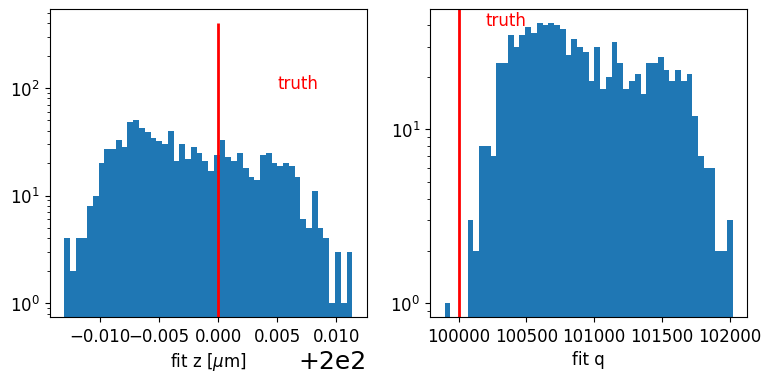

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].hist(z_fit, bins=50)
ax[0].set_xlabel(r'fit z [$\mu$m]', fontsize=12)
ax[0].vlines(200.0, 0, 400, color='red', lw=2)
ax[0].text(200.005, 100, 'truth', color='red', fontsize=12)
ax[0].semilogy()
ax[0].tick_params(axis='both', labelsize=12)

ax[1].hist(np.array(q_fit)*1e5, bins=50)
ax[1].set_xlabel(r'fit q', fontsize=12)
ax[1].semilogy()
ax[1].vlines(1e5, 0, 100, color='red', lw=2)
ax[1].text(100200, 40, 'truth', color='red', fontsize=12)
ax[1].tick_params(axis='both', labelsize=12)

print(f'Fitting resolution for z position is {np.std(z_fit)/np.mean(z_fit)*100:.6f}%, with bias {(np.mean(z_fit)-200)/200.:.6f}%.')
print(f'Fitting resolution for 100000 e- is {np.std(q_fit)/np.mean(q_fit)*100:.2f}%, with bias {np.mean(q_fit)*1e5/1e5*100-100:.2f}%.')

In [ ]:
# generate 1000 one-cluster induction waveforms and store into h5 file.
#### Generate collection waveforms from two clusters
import numpy as np
from tqdm.notebook import tqdm

from TEclusters import processor
proc = processor()

x_c0, y_c0, z_c0, q_c0, t_c0 = 1.5, 4., 220., 1e5, 0
amp_c_sets = []
for i in tqdm(range(1000)):
    amp_c = proc.dummy_combination([(x_c0, y_c0, z_c0)], [t_c0], [q_c0])
    amp_c_sets.append(amp_c)

import h5py
with h5py.File('induction_waveforms_3.h5', 'w') as f:
    for i in range(1000):
        name = f'waveform_{i}'
        f.create_dataset(name, data=amp_c_sets[i])




  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


In [ ]:
import h5py
from tqdm.notebook import tqdm
import numpy as np
x_fit = []
y_fit = []
z_fit = []
q_fit = []
chi2_fit = []

fit_examples = []
n_failed = 0
failed_evtNo = []
failed_fitter = []

xi, yi, zi, qi, ti = 1.5, 4.0, 220, 1.0, 0

with h5py.File('./induction_waveforms_3.h5', 'r') as f:
    iwf = 0
    for dset_name in tqdm(f.keys()):
        wf = f[dset_name]
        wf_copy = []
        for i in wf:
            wf_copy.append(i)
        wf_copy = wf_copy
        time = np.arange(len(wf_copy)) * 0.5

        m = fitter.dummy_oneInductionWF_fitting(time, wf_copy, [ti, xi, yi, zi, qi])
        if m:
            z0, q0 = m.values['z0'], m.values['q0']
            x0, y0 = m.values['x0'], m.values['y0']
            x_fit.append(x0)
            y_fit.append(y0)
            z_fit.append(z0)
            q_fit.append(q0)
            chi2_fit.append(m.fval)

        elif m == False or m.fval > 1000:
            # Re-fit 3 more time:
            for refit in range(6):
                err = 0.03
                m = fitter.dummy_oneInductionWF_fitting(time, wf, [ti, xi*np.random.uniform(0.9, 1.1), yi*np.random.uniform(0.9, 1.1), zi, qi*np.random.uniform(0.9, 1.1)])
                if m:
                    z0, q0 = m.values['z0'], m.values['q0']
                    x0, y0 = m.values['x0'], m.values['y0']
                    x_fit.append(x0)
                    y_fit.append(y0)
                    z_fit.append(z0)
                    q_fit.append(q0)
                    chi2_fit.append(m.fval)
                    break
            if m == False or m.fval > 1000:
                n_failed += 1
                failed_evtNo.append(iwf)
                fit_examples.append(time)
                fit_examples.append(wf_copy)
                fit_examples.append([0, xi, yi, zi, qi])

                if m:
                    failed_fitter.append(m)
            
        iwf += 1        



  0%|          | 0/1000 [00:00<?, ?it/s]

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 2.39582e+09 Requested 0.0002
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0247732
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 2.24359e+10 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 100.501 Requested 0.0002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 2.96682e+08 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 3.68376e+08 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid af

In [ ]:
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 224.1 (χ²/ndof = 0.8)      │              Nfcn = 400              │
│ EDM = 1.75e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t0   │    0.0    │    0.1    │            │            │  -500   │   500   │  yes  │
│ 1 │ x0   │1.4999999996│0.0000000024│            │            │  1.05   │  1.95   │       │
│ 2 │ y0   │  3.99954  │  0.00026  │            │            │    3    │   5.2   │       │
│ 3 │ z0   │  219.973  │   0.022   │            │            │   209   │   231   │       │
│ 4 │ q0   │   1.005   │   0.008   │            │            │   0.9   │   1.1   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────────────────────────────────────────┐
│    │             t0             x0             y0             z0             q0 │
├────┼────────────────────────────────────────────────────────────────────────────┤
│ t0 │              0          0e-18              0              0              0 │
│ x0 │          0e-18       6.02e-18    530.716e-15 -44.005792e-12  -9.144624e-12 │
│ y0 │              0    530.716e-15        6.6e-08       -3.56e-6       -0.53e-6 │
│ z0 │              0 -44.005792e-12       -3.56e-6       0.000483        0.08e-3 │
│ q0 │              0  -9.144624e-12       -0.53e-6        0.08e-3       6.62e-05 │
└────┴────────────────────────────────────────────────────────────────────────────┘

1.0046809415610851 0.008


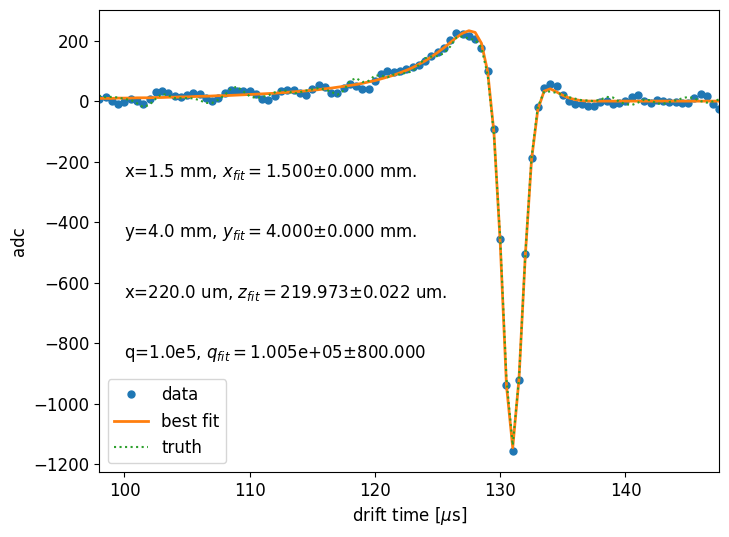

In [ ]:
fitter.dummy_oneInductionWF_fitting_plot(time, wf_copy, [0, x_fit[-1], y_fit[-1], z_fit[-1], q_fit[-1]], [0.1, 0.00000, 0.00026, 0.022, 0.008])

0.9841515264481876 1.4999999997683957 3.988987682061222 219.96185772478992
223.37305111149863


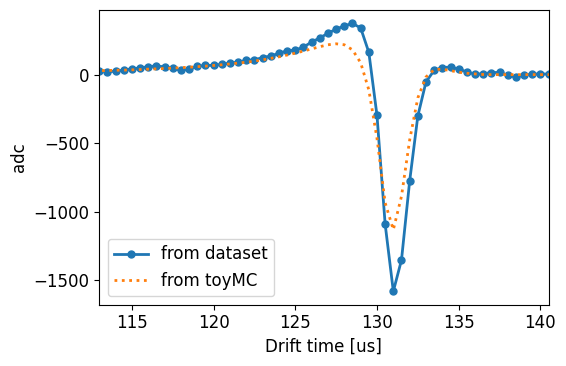

In [ ]:
evtNo = 112
print(q_fit[evtNo], x_fit[evtNo], y_fit[evtNo], z_fit[evtNo])
print(m.fval)
from toyMC_loader import toyMC_loader
toyMCloader = toyMC_loader()
toyMCloader.toyMC_filename = '/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/induction_waveforms_2.h5'
#toyMCloader.display_event(21, 1e5, 1, 3, 220)
#toyMCloader.display_event(41, 1e5, 1, 3, 220)
#toyMCloader.display_event(81, 1e5, 1, 3, 220)
toyMCloader.display_event(evtNo, q_fit[evtNo]*1e5, x_fit[evtNo], y_fit[evtNo], z_fit[evtNo])

219.97104468361144
Fitting resolution for 100000 e- is 0.01%, with 0.01316 bias.
Fitting resolution for 100000 e- is 1.62%, with -0.17478 bias.


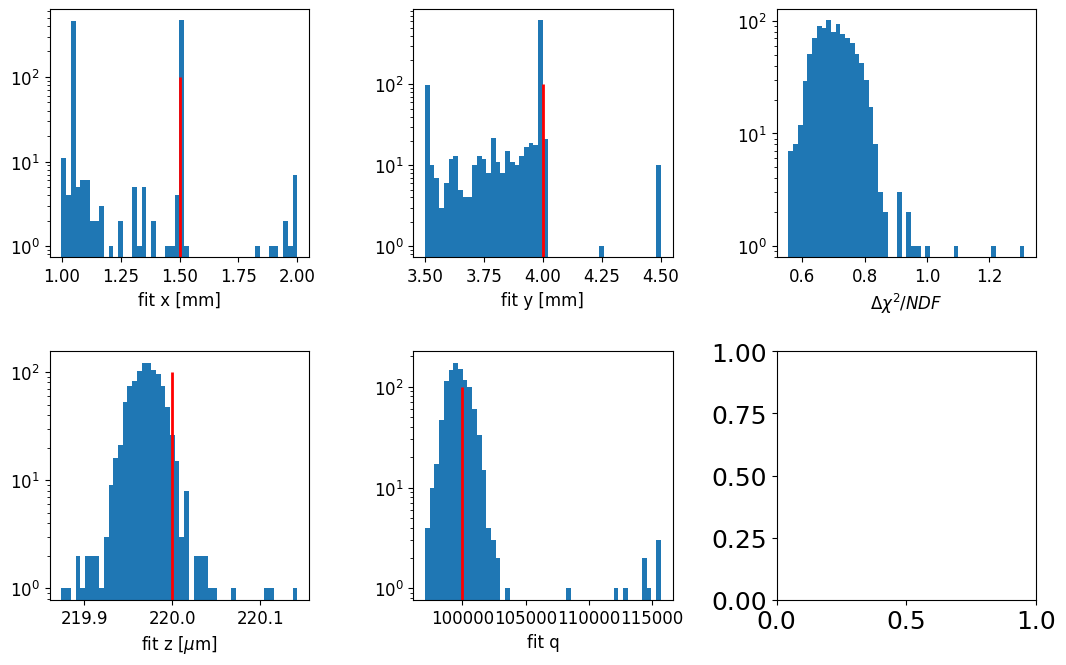

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(11, 7))

ax[0, 0].hist(x_fit, bins=50)
ax[0, 0].set_xlabel('fit x [mm]', fontsize=12)
ax[0, 0].tick_params(axis='both', labelsize=12)
ax[0, 0].vlines(1.5, 0, 100, color='red', lw=2)
ax[0, 0].semilogy()

ax[0, 1].hist(y_fit, bins=50)
ax[0, 1].set_xlabel('fit y [mm]', fontsize=12)
ax[0, 1].tick_params(axis='both', labelsize=12)
ax[0, 1].vlines(4.0, 0, 100, color='red', lw=2)
ax[0, 1].semilogy()

ax[1, 0].hist(z_fit, bins=50)
ax[1, 0].set_xlabel(r'fit z [$\mu$m]', fontsize=12)
ax[1, 0].tick_params(axis='both', labelsize=12)
ax[1, 0].semilogy()
ax[1, 0].vlines(220, 0, 100, color='red', lw=2)
print(np.mean(z_fit))
print(f'Fitting resolution for 100000 e- is {np.std(z_fit)/np.mean(z_fit)*100:.2f}%, with {(220-np.mean(z_fit))/220*100:.5f} bias.')

ax[1, 1].hist(np.array(q_fit)*1e5, bins=50)
ax[1, 1].set_xlabel(r'fit q', fontsize=12)
ax[1, 1].tick_params(axis='both', labelsize=12)
ax[1, 1].semilogy()
ax[1, 1].vlines(1e5, 0, 100, color='red', lw=2)
print(f'Fitting resolution for 100000 e- is {np.std(q_fit)/np.mean(q_fit)*100:.2f}%, with {(np.mean(q_fit)*1e5-1e5)/1e5*100:.5f} bias.')

ax[0, 2].hist(np.array(chi2_fit)/296., bins=50)
ax[0, 2].set_xlabel(r'$\Delta\chi^2/NDF$', fontsize=12)
ax[0, 2].tick_params(axis='both', labelsize=12)
ax[0, 2].semilogy()

plt.tight_layout()

### Re-grouping PDFs
The uniform dividing of PDF grids seems not very suitable as only those charge close to the strip has obvious contributions to the final waveforms. Try to change the grid size with respect to the distance to the strip.

In [ ]:
# Generate grid PDFs and save them into h5 files.

from tqdm.notebook import tqdm
import numpy as np
from SignalCalculator import SignalCalculator
from toy_digitization import digitization

digi = digitization(SamplingFrequency=2.0)

X, Y = [], []
Xmin, Xmax = -48, 48
Ymin, Ymax = -30, 30
xs = [-48, -40, -20, -10, 10, 20, 40, 48]
step_xs =[ 4, 2, 1, 0.5, 1, 2, 4 ]
ys = [-30, -20, -10, 10, 20, 30]
step_ys = [2, 1, 0.5, 1, 2]

for i in range(len(step_xs)):
    num = int((xs[i+1]-xs[i]) / step_xs[i])
    for j in range(num):
        X.append(xs[i] + j * step_xs[i])
X.append(Xmax)

for i in range(len(step_ys)):
    num = int((ys[i+1]-ys[i]) / step_ys[i])
    for j in range(num):
        Y.append(ys[i] + j * step_ys[i])
Y.append(Ymax)

z = 100 
q = 1e5
induction_pdfs = {}
for x in tqdm(X):
    for y in Y:
        pdf_name = f'x{x}y{y}'
        tt, wf = SignalCalculator.ComputeChargeWaveformOnStripWithIons(q, x, y, z)
        digi.convolve_asic_response(tt, wf)
        digi.generate_noise(len(digi.cryoAmp))
        digi.quantization(digi.cryoAmp, digi.asic_noise_amp, 40000.)
        pdf = digi.get_quantized_truthWF()
        induction_pdfs[pdf_name] = pdf



import h5py

with h5py.File('gridPDFs_induction_nonuniform.h5', 'w') as f:
    for name, pdf in induction_pdfs.items():
        f.create_dataset(name, data=pdf)



  0%|          | 0/85 [00:00<?, ?it/s]

/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


Total generated 1324 points for PDF templates.
Total generated 1324 points for PDF templates.


  0%|          | 0/1324 [00:00<?, ?it/s]

/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


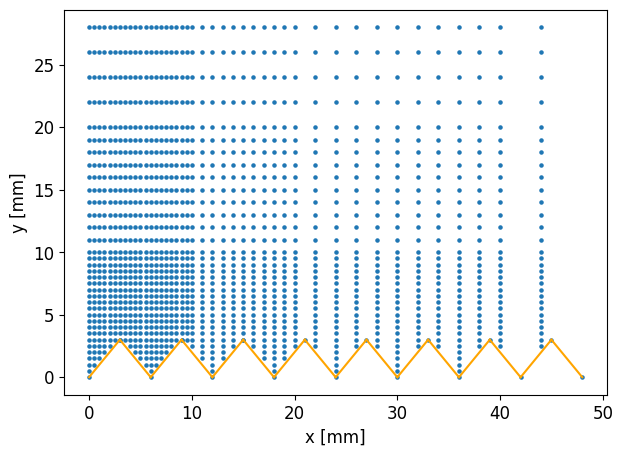

In [21]:
from generate_PDFs import pdf_generator
gen = pdf_generator()
gen._generate_coordinates()

import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(7, 5))
for i in range(16):
    if not i%2:
        y1, y2 = 0, 3
    else:
        y1, y2 = 3, 0 
    ax.plot([3*i, 3*(i+1)], [y1, y2], '-', color='orange')
ax.scatter(gen.X, gen.Y, s=5)
ax.set_xlabel('x [mm]', fontsize=12)
ax.set_ylabel('y [mm]', fontsize=12)
ax.tick_params(axis='both', labelsize=12)

gen._set_filename('./gridPDFs_induction_nonuniform_simplified_new.h5')
gen._generate_PDFs(1e5, 100)


1.5 1.5 2.0 1.0
1.6 1.5 2.0 0.7999999999999998
1.7 1.5 2.0 0.6000000000000001
1.8 1.5 2.0 0.3999999999999999
1.9 1.5 2.0 0.20000000000000018
2.0 2.0 2.5 1.0
2.1 2.0 2.5 0.7999999999999998
2.2 2.0 2.5 0.5999999999999996
2.3 2.0 2.5 0.40000000000000036
2.4 2.0 2.5 0.20000000000000018
2.5 2.5 3.0 1.0


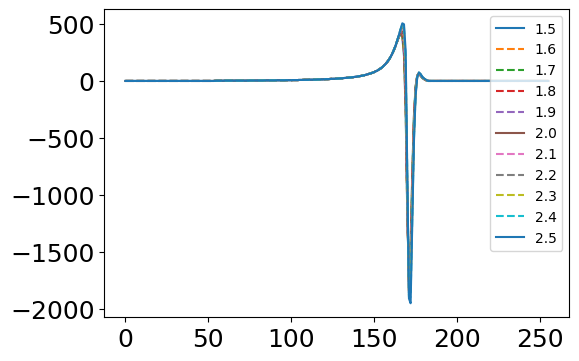

In [4]:
from waveform_fit import fitter
import matplotlib.pyplot as plt
import numpy as np
fit = fitter(SamplingFrequency=2.0)
fit.load_gridPDFs()

x = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
y = [3.0 for _ in range(len(x))]

fig, ax = plt.subplots(figsize=(6, 4))
for xi, yi in zip(x, y):
    if xi == 1.5 or xi == 2.0 or xi == 2.5:
        ax.plot(fit.PDF_interpolation(xi, yi), label=f'{xi:.1f}')
    else:
        ax.plot(fit.PDF_interpolation(xi, yi), '--', label=f'{xi:.1f}')
    
#ax.set_ylim(400, 520)
#ax.set_xlim(160, 170)
ax.legend(prop={'size':10})

### Generate toyMC channels with the same point charge
We want to generate channels with fixed point charge position.

In [42]:

from toyMC_generator import toyMC_generator
gen = toyMC_generator()

gen.filename = './toyMC_data/multi_waveforms_xstripX0Y0X0Y6_chargeX3Y1.h5'
gen.total_entries = 1000

x_xstrip = [0., 0.,  ]
y_xstrip = [0., 6.0, ]
x_ystrip = [ ]
y_ystrip = [ ]
q0, x0, y0, z0 = 1e5, 3.0, 1.0, 100.0

gen.generate_bunches(x_xstrip, y_xstrip, x_ystrip, y_ystrip, q0, x0, y0, z0)
gen.save_waveforms()



  0%|          | 0/1000 [00:00<?, ?it/s]

In [43]:

from toyMC_generator import toyMC_generator
gen = toyMC_generator()

gen.filename = './toyMC_data/multi_waveforms_xstripX0Y0X0Y-6_chargeX3Y1.h5'
gen.total_entries = 1000

x_xstrip = [0., 0.,]
y_xstrip = [0., -6 ]
x_ystrip = [ ]
y_ystrip = [ ]
q0, x0, y0, z0 = 1e5, 3.0, 1.0, 100.0

gen.generate_bunches(x_xstrip, y_xstrip, x_ystrip, y_ystrip, q0, x0, y0, z0)
gen.save_waveforms()



  0%|          | 0/1000 [00:00<?, ?it/s]

In [44]:

from toyMC_generator import toyMC_generator
gen = toyMC_generator()

gen.filename = './toyMC_data/multi_waveforms_xstripX0Y0X0Y6X0Y-6_chargeX3Y1.h5'
gen.total_entries = 1000

x_xstrip = [0., 0., 0.,]
y_xstrip = [0., 6., -6 ]
x_ystrip = [ ]
y_ystrip = [ ]
q0, x0, y0, z0 = 1e5, 3.0, 1.0, 100.0

gen.generate_bunches(x_xstrip, y_xstrip, x_ystrip, y_ystrip, q0, x0, y0, z0)
gen.save_waveforms()



  0%|          | 0/1000 [00:00<?, ?it/s]

In [45]:

from toyMC_generator import toyMC_generator
gen = toyMC_generator()

gen.filename = './toyMC_data/multi_waveforms_xstripX0Y0X0Y6_ystripX0Y0_chargeX3Y1.h5'
gen.total_entries = 1000

x_xstrip = [0., 0.,]
y_xstrip = [0., 6.,]
x_ystrip = [0, ]
y_ystrip = [0, ]
q0, x0, y0, z0 = 1e5, 3.0, 1.0, 100.0

gen.generate_bunches(x_xstrip, y_xstrip, x_ystrip, y_ystrip, q0, x0, y0, z0)
gen.save_waveforms()



  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
from toyMC_generator import toyMC_generator
gen = toyMC_generator()

gen.filename = 'multi_waveforms_0.h5'
gen.total_entries = 100

x_xstrip = [0, 0, 0, 0, 0]
y_xstrip = [-12, -6, 0, 6, 12]
x_ystrip = [-9, -3, 3, 9]
y_ystrip = [0, 0, 0, 0]
Q0, x0, y0, z0 = 1e5, 3, 0, 100

gen.generate_bunches(x_xstrip, y_xstrip, x_ystrip, y_ystrip , Q0, x0, y0, z0)
gen.save_waveforms()

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


### Add diffusion process in PDF generation
Two gaussian diffusion.

In [ ]:

from toy_digitization import digitization
digi = digitization(SamplingFrequency=2.)
digi.diffusion_process(1e5, 3, 0, 1000)

Info: transverse diffusion coefficient 2.497057091387191 mm, longitudinal diffusion coefficient 1.7081121329770859 mm in 588.2352941176471 us.


## nEXO offline simulation waveforms
Try the fitting tool on the nEXO offline simulated waveforms.

In [2]:
import sys
sys.path.append('../')

from nEXO_loader import loader
loader = loader()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


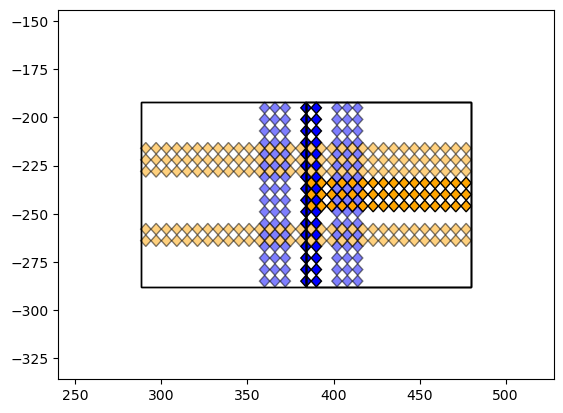

In [3]:
loader.load_nentries = 5
loader._load_event()
loader._plot_topo2d(3)

(250.0, 300.0)

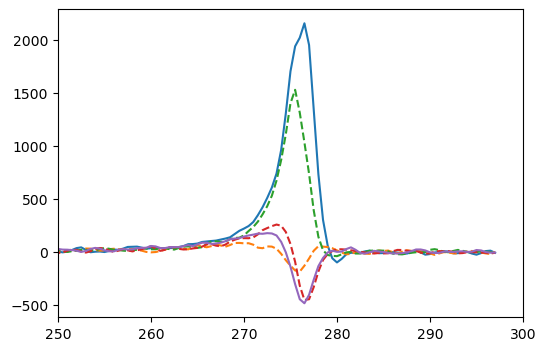

In [4]:
one_event = loader._get_one_event(3)

import numpy as np
import matplotlib.pyplot as plt

coll_wf = []
fig, ax = plt.subplots(figsize=(6, 4))
for q, wf, chaid in zip(one_event['q'], one_event['wf'], one_event['localid']):
    if q > 600 and chaid < 16:
        ax.plot(np.arange(len(wf))*0.5, wf)
        coll_wf.append(wf)
    if q > 600 and chaid >= 16:
        ax.plot(np.arange(len(wf))*0.5, wf, '--')
        coll_wf.append(wf)
        
ax.set_xlim(250, 300)

In [ ]:
wf0 = np.array(coll_wf[2])
t0 = np.arange(len(wf0)) * 0.5

m = fitter.dummy_oneCollectionWF_fitting(t0, wf0, [0, 460, 0.4])

In [ ]:
m.interactive(model_points=1000)

## Multi-channel fitting
See the resolution improvement when combining multi-channels.

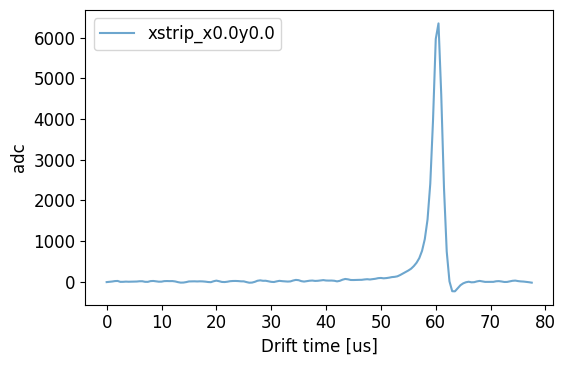

In [20]:
from toyMC_loader import toyMC_loader
loader = toyMC_loader()
loader.toyMC_filename = './toyMC_data/multi_waveforms_xstripX0Y0_chargeX3Y1.h5'
#loader.toyMC_filename = 'multi_waveforms_xstripX0Y0_ystripX6Y0_chargeX3Y1.h5'
evtid = 29
loader.load_h5file_multiChannels(evtid)
loader.display_event_multiChannels(evtid)
times, wfs, sxs, sys, ystrips = loader.assembling_for_fitter()

In [23]:
from importlib import reload
import waveform_fit

reload(waveform_fit)
from waveform_fit import fitter

fitter = fitter(SamplingFrequency=2)

# Load the pre-produced grid PDFs:
fitter.load_gridPDFs()

m = fitter.oneCluster_fitting(times, wfs, 0, 3.0, 1.0, 100., 1.0, sxs, sys, ystrips)
m

describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 1.0).
Error! There is no boundary points for (41.9227756910392, 1.0)!!! CHECK-REQUIRED!!!
Error! There is no boundary points for (41.14763445072462, 1.0)!!! CHECK-REQUIRED!!!
Error! There is no boundary points for (41.0775080098604, 1.0)!!! CHECK-REQUIRED!!!
Error! There is no boundary points for (41.29708240866427, 0.9960528887007056)!!! CHECK-REQUIRED!!!
Error! There is no boundary points for (41.29708240866427, 0.9960528887007056)!!! CHECK-REQUIRED!!!
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 4082.32 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.000102052
W MnPosDef Added to diagonal of Error matrix a value 0.500103
W VariableMetricBuilder gdel = -1.69298e+08
Error! There is no boundary points for (41.73768980864752, 0.9960439127540195)!!! CHECK-REQ

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 308.8 (χ²/ndof = 2.0)      │              Nfcn = 393              │
│ EDM = 2.1e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t0   │    0.0    │    0.1    │            │            │  -500   │   500   │  yes  │
│ 1 │ x0   │ -3.8732e1 │ 0.0000e1  │            │            │   -42   │   42    │       │
│ 2 │ y0   │-1.4597e-2 │ 0.0000e-2 │            │            │   -3    │    5    │       │
│ 3 │ z0   │ 1.0008e2  │ 0.0000e2  │            │            │   80    │   120   │       │
│ 4 │ Q0   │  1.0276   │  0.0000   │            │            │   0.8   │   1.2   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [22]:
# interactive fitting.
m.interactive()

In [1]:
# batch fitting:
from tqdm.notebook import tqdm
    
from importlib import reload
import waveform_fit

reload(waveform_fit)
from waveform_fit import fitter

fitter = fitter(SamplingFrequency=2)

# Load the pre-produced grid PDFs:
fitter.load_gridPDFs()

from toyMC_loader import toyMC_loader
loader = toyMC_loader()

#input_list = ['./toyMC_data/multi_waveforms_xstripX0Y0X0Y6_chargeX3Y1.h5', \
#              './toyMC_data/multi_waveforms_xstripX0Y0X0Y6X0Y-6_chargeX3Y1.h5', \
#              './toyMC_data/multi_waveforms_xstripX0Y0X0Y6X0Y-6X0Y12_chargeX3Y1.h5', \
#              './toyMC_data/multi_waveforms_xstripX0Y0X0Y6X0Y-6X0Y12X0Y-12_chargeX3Y1.h5', \
#              './toyMC_data/multi_waveforms_xstripX0Y0X0Y6X0Y-6X0Y12X0Y-12X0Y18_chargeX3Y1.h5', \
#              './toyMC_data/multi_waveforms_xstripX0Y0X0Y6X0Y-6X0Y12X0Y-12X0Y18X0Y-18_chargeX3Y1.h5'
#              ]
#labels = ['2 x-strips', '3 x-strips', '4 x-strips', '5 x-strips', '6 x-strip', '7 x-strip']

input_list = [ 
              './toyMC_data/multi_waveforms_xstripX0Y-18_chargeX3Y1.h5', \
              './toyMC_data/multi_waveforms_xstripX0Y-12_chargeX3Y1.h5', \
              './toyMC_data/multi_waveforms_xstripX0Y-6_chargeX3Y1.h5', \
              './toyMC_data/multi_waveforms_xstripX0Y0_chargeX3Y1.h5', \
              './toyMC_data/multi_waveforms_xstripX0Y6_chargeX3Y1.h5', \
              './toyMC_data/multi_waveforms_xstripX0Y12_chargeX3Y1.h5', \
              './toyMC_data/multi_waveforms_xstripX0Y18_chargeX3Y1.h5', \
             ]

labels = ['X0Y-18', 'X0Y-12', 'X0Y-6', 'X0Y0', 'X0Y6', 'X0Y12', 'X0Y18']

#input_list = [  
#                './toyMC_data/multi_waveforms_xstripX0Y0_chargeX3Y1.h5', \
#                './toyMC_data/multi_waveforms_xstripX0Y6_chargeX3Y1.h5', \
#                './toyMC_data/multi_waveforms_xstripX0Y-6_chargeX3Y1.h5', \
#                './toyMC_data/multi_waveforms_xstripX0Y0X0Y6_chargeX3Y1.h5', \
#                './toyMC_data/multi_waveforms_xstripX0Y0X0Y-6_chargeX3Y1.h5', \
#                './toyMC_data/multi_waveforms_xstripX0Y0X0Y6X0Y-6_chargeX3Y1.h5' ,\
#                './toyMC_data/multi_waveforms_xstripX0Y0X0Y6_ystripX0Y0_chargeX3Y1.h5'
#]
#
#labels = ['x-strip: X0Y0', 'x-strip: x0y6', 'x-strip: x0y-6', 'x-strip: x0y0x0y6', 'x-strip: x0y0x0y-6', 'x-strip: x0y0x0y6x0y-6', 'x-strip: x0y0x0y6, y-strip: x0y0']

x0, y0, z0, q0, t0 = 3.0, 1.0, 100., 1.0, 0
fit_results = {}

for i, filename in enumerate(input_list):
    loader.toyMC_filename = filename
    tmp_dict = {}
    x_fit, y_fit, z_fit, q_fit = [], [], [], []
    print(filename)
    for evtid in tqdm(range(1000)):
        loader.load_h5file_multiChannels(evtid)
        #loader.display_event_multiChannels(evtid)
        times, wfs, sxs, sys, ystrips = loader.assembling_for_fitter()

        m = fitter.oneCluster_fitting(times, wfs, t0, x0, y0, z0, q0, sxs, sys, ystrips)
        x_fit.append(m.values['x0'])
        y_fit.append(m.values['y0'])
        z_fit.append(m.values['z0'])
        q_fit.append(m.values['Q0'])
        
    tmp_dict['fit_x'] = x_fit
    tmp_dict['fit_y'] = y_fit
    tmp_dict['fit_z'] = z_fit
    tmp_dict['fit_q'] = q_fit
    
    fit_results[labels[i]] = tmp_dict


./toyMC_data/multi_waveforms_xstripX0Y-18_chargeX3Y1.h5


  0%|          | 0/1000 [00:00<?, ?it/s]

describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 19.0).
W VariableMetricBuilder No improvement in line search
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.0734451 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W MnGlobalCorrelationCoeff inversion of matrix fails
Error!! nan within (None, None), 17.999986329183763 within (17.0, 18.0).
Error! There is no boundary points for (nan, 17.999986329183763)!!! CHECK-REQUIRED!!!
Error!! nan within (None, None), 17.999986329183763 within (17.0, 18.0).
Error! There is no boundary points for (nan, 17.999986329183763)!!! CHECK-REQUIRED!!!
Error!! nan within (None, None), 17.999986329183763 within (17.0, 18.0).
Error! There is no boundary points for (nan, 17.999986329183763)!!! CHECK-REQUIR

  0%|          | 0/1000 [00:00<?, ?it/s]

describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 13.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 13.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 13.0).
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -88.058
W MnPosDef Added to diagonal of Error matrix a value 88.558
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 13.0).
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0471663
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.323109 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetricBuilder No improvement in line search
describe(least_squres_total)=['t0

  0%|          | 0/1000 [00:00<?, ?it/s]

describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 7.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 7.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 7.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 7.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 7.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 7.0).
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -4585.63
W MnPosDef Added to diagonal of Error matrix a value 4586.13
W MnPosDef Matrix forced pos-def by adding to diagonal 14.2087
W DavidonErrorUpdator delgam < 0 : first derivatives increas

  0%|          | 0/1000 [00:00<?, ?it/s]

describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, 1.0).
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 1.94696e+10 Requested 0.0002
W MnHesse 2nd derivative zero for parameter y0 ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No convergence; Edm 6.77204e+09 is above tolerance 0.002
W MnHesse 2nd derivative zero for parameter x0 ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W MnHesse 2nd derivative zero for parameter x0 ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W MnHesse 2nd derivative zero for parameter x0 ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W MnHesse 

  0%|          | 0/1000 [00:00<?, ?it/s]

describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -5.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -5.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -5.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -5.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -5.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -5.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -5.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -5.0).
describe

  0%|          | 0/1000 [00:00<?, ?it/s]

describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -11.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -11.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -11.0).
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -414.506
W MnPosDef Added to diagonal of Error matrix a value 415.006
W MnPosDef Matrix forced pos-def by adding to diagonal 0.515439
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -11.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -11.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -11.0).
describe(least_squres_total)=['t0', 'x0', 'y0',

  0%|          | 0/1000 [00:00<?, ?it/s]

describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -17.0).
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.00842211 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 2.32477 Requested 0.0002
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -17.0).
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -17.0).
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -9.4744e-10
W MnPosDef Added to diagonal of Error matrix a value 0.500001
describe(least_squres_total)=['t0', 'x0', 'y0', 'z0', 'Q0'].
Local coordinates for the charge on strip0 (x) is (3.0, -1

In [4]:
import matplotlib.pyplot as plt
import numpy as np
    
def plot_histograms(fit_results):
    print(fit_results.keys())
    fig, ax = plt.subplots(1, 4, figsize=(14, 4))
    for i, (lb, tmpdict) in enumerate(fit_results.items()):
        ax[0].hist(tmpdict['fit_x'], bins=20, range=(-40, 40),    histtype='step', lw=1.5, label=lb)
        ax[1].hist(tmpdict['fit_y'], bins=20, range=(-5, 6.0),  histtype='step', lw=1.5, label=lb)
        ax[2].hist(tmpdict['fit_z'], bins=20, range=(97, 103),  histtype='step', lw=1.5, label=lb)
        ax[3].hist(tmpdict['fit_q'], bins=20, range=(0.5, 1.5),    histtype='step', lw=1.5, label=lb)

    ax[0].set_xlabel('fit x [mm]', fontsize=12)
    ax[0].tick_params(axis='both', labelsize=12)
    ax[0].semilogy()
    ax[1].set_xlabel('fit y [mm]', fontsize=12)
    ax[1].tick_params(axis='both', labelsize=12)
    ax[1].semilogy()
    ax[2].set_xlabel('fit z [mm]', fontsize=12)
    ax[2].tick_params(axis='both', labelsize=12)
    ax[2].semilogy()
    ax[3].set_xlabel('fit q', fontsize=12)
    ax[3].tick_params(axis='both', labelsize=12)
    ax[3].semilogy()

    ax[2].legend(prop={'size':12})
    plt.tight_layout()
    plt.show()

    print('-> X resolution:')
    for lb, fits in fit_results.items():
        stddev = np.std(fits['fit_x']) 
        mean = np.mean(fits['fit_x'])
        res = stddev / mean
        bias = (np.mean(fits['fit_x'])- 3.0) / 3.0
        print(f'{lb}: resolution {res*100:.3}% with {bias*100:.3}% bias (mean = {mean:.3f}, stddev = {stddev:.3f}).')

    print('-> Y resolution:')
    for lb, fits in fit_results.items():
        stddev = np.std(fits['fit_y']) 
        mean = np.mean(fits['fit_y'])
        res = stddev / mean
        bias = (np.mean(fits['fit_y'])- 1.0) / 1.0
        print(f'{lb}: resolution {res*100:.3}% with {bias*100:.3}% bias (mean = {mean:.3f}, stddev = {stddev:.3f}).')

    print('-> Z resolution:')
    for lb, fits in fit_results.items():
        stddev = np.std(fits['fit_z']) 
        mean = np.mean(fits['fit_z'])
        res = stddev / mean
        bias = (np.mean(fits['fit_z'])- 100.0) / 100.0
        print(f'{lb}: resolution {res*100:.3}% with {bias*100:.3}% bias (mean = {mean:.3f}, stddev = {stddev:.3f}).')

    print('-> Energy reconstruction:')
    for lb, fits in fit_results.items():
        stddev = np.std(fits['fit_q']) *1e5
        mean = np.mean(fits['fit_q']) *1e5
        res = stddev / mean
        bias = (np.mean(fits['fit_q'])*1e5 - 1e5) /1e5
        print(f'{lb}: resolution {res*100:.3}% with {bias*100:.3}% bias (mean = {mean:.3f}, stddev = {stddev:.3f}).')

def plot_linecharts(fit_results):
    fig, ax = plt.subplots(2, 4, figsize=(14, 7))
    x_fit_bias, x_fit_res = [], []
    y_fit_bias, y_fit_res = [], []
    z_fit_bias, z_fit_res = [], []
    q_fit_bias, q_fit_res = [], []
    
    x0, y0, z0, q0 = 3.0, 1.0, 100.0, 1.0
    
    xticks = []
    for lb, tmpdict in fit_results.items():
        x_fit_bias.append( (np.mean(tmpdict['fit_x']) - x0))
        x_fit_res.append(np.std(tmpdict['fit_x']))
    
        y_fit_bias.append( (np.mean(tmpdict['fit_y']) - y0))
        y_fit_res.append(np.std(tmpdict['fit_y']))
    
        z_fit_bias.append( (np.mean(tmpdict['fit_z']) - z0))
        z_fit_res.append(np.std(tmpdict['fit_z']))
    
        q_fit_bias.append( (np.mean(tmpdict['fit_q']) - q0)*1e5)
        q_fit_res.append(np.std(tmpdict['fit_q']) / np.mean(tmpdict['fit_q'])*100)
        
        xticks.append(lb)
    
    ax[0, 0].plot(x_fit_bias, 'o-', color='blue')
    ax[1, 0].plot(x_fit_res, 's-',  color='crimson')
    ax[0, 1].plot(y_fit_bias, 'o-', color='blue')
    ax[1, 1].plot(y_fit_res, 's-', color='crimson')
    ax[0, 2].plot(z_fit_bias, 'o-', color='blue')
    ax[1, 2].plot(z_fit_res, 's-', color='crimson')
    ax[0, 3].plot(q_fit_bias, 'o-', color='blue')
    ax[1, 3].plot(q_fit_res, 's-', color='crimson')
    for i in range(4):
        ax[0, i].hlines(0, 0, len(x_fit_bias)+1, color='orange', lw=2, linestyle='--')
    
    ax[0, 0].set_ylabel('x bias [mm]', fontsize=12)
    ax[0, 0].tick_params(axis='y', labelsize=12)
    ax[0, 0].tick_params(axis='x', labelsize=0)
    ax[0, 1].set_ylabel('y bias [mm]', fontsize=12)
    ax[0, 1].tick_params(axis='y', labelsize=12)
    ax[0, 1].tick_params(axis='x', labelsize=0)
    ax[0, 2].set_ylabel('z bias [mm]', fontsize=12)
    ax[0, 2].tick_params(axis='y', labelsize=12)
    ax[0, 2].tick_params(axis='x', labelsize=0)
    ax[0, 3].set_ylabel('q bias', fontsize=12)
    ax[0, 3].tick_params(axis='y', labelsize=12)
    ax[0, 3].tick_params(axis='x', labelsize=0)
    ax[1, 0].set_ylabel('x resolution [mm]', fontsize=12)
    ax[1, 0].tick_params(axis='both', labelsize=12)
    ax[1, 1].tick_params(axis='both', labelsize=12)
    ax[1, 1].set_ylabel('y resolution [mm]', fontsize=12)
    ax[1, 2].tick_params(axis='both', labelsize=12)
    ax[1, 2].set_ylabel('z resolution [mm]', fontsize=12)
    ax[1, 3].tick_params(axis='both', labelsize=12)
    ax[1, 3].set_ylabel('q resolution [%]', fontsize=12)
    
    #ax[1, 2].legend(prop={'size':12})
    
    ax[1, 0].set_xticks(range(len(xticks)), xticks, rotation=30, fontsize=8)
    ax[1, 1].set_xticks(range(len(xticks)), xticks, rotation=30, fontsize=8)
    ax[1, 2].set_xticks(range(len(xticks)), xticks, rotation=30, fontsize=8)
    ax[1, 3].set_xticks(range(len(xticks)), xticks, rotation=30, fontsize=8)
    
    fig.text(0.39, 0.98, '1e5 point charge at (3 mm, 1 mm, 100 mm)', fontsize=12)
    
    
    plt.tight_layout()


dict_keys(['X0Y-18', 'X0Y-12', 'X0Y-6', 'X0Y0', 'X0Y6', 'X0Y12', 'X0Y18'])


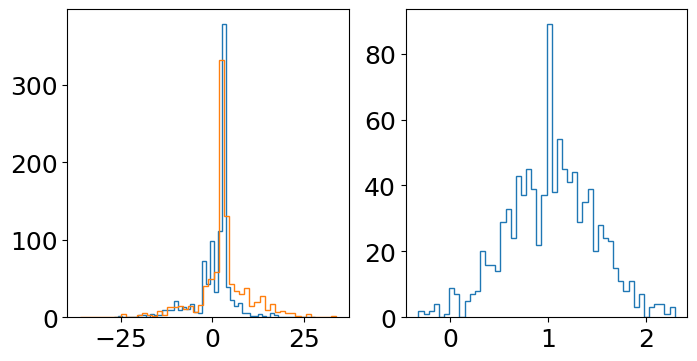

In [36]:
print(fit_results.keys())
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(fit_results['X0Y12']['fit_x'],  bins=50, histtype='step');
ax[0].hist(fit_results['X0Y-12']['fit_x'], bins=50, histtype='step');
ax[1].hist(fit_results['X0Y12']['fit_y'],  bins=50, histtype='step');

dict_keys(['X0Y-18', 'X0Y-12', 'X0Y-6', 'X0Y0', 'X0Y6', 'X0Y12', 'X0Y18'])


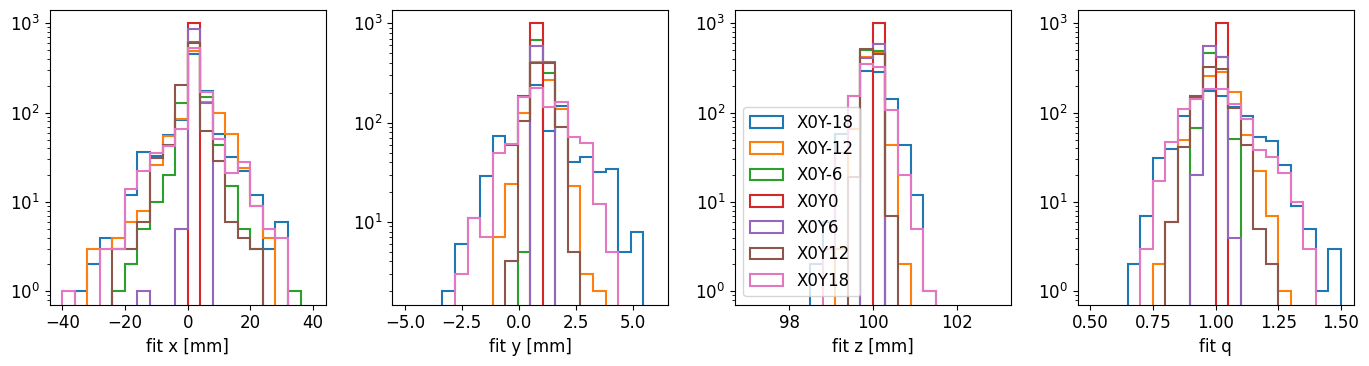

-> X resolution:
X0Y-18: resolution 3.24e+02% with -20.5% bias (mean = 2.386, stddev = 7.723).
X0Y-12: resolution 2.04e+02% with 11.4% bias (mean = 3.342, stddev = 6.808).
X0Y-6: resolution 1.58e+02% with -10.9% bias (mean = 2.673, stddev = 4.230).
X0Y0: resolution 0.00256% with 0.000211% bias (mean = 3.000, stddev = 0.000).
X0Y6: resolution 39.1% with -2.7% bias (mean = 2.919, stddev = 1.140).
X0Y12: resolution 3.45e+02% with -57.1% bias (mean = 1.286, stddev = 4.440).
X0Y18: resolution 2.69e+02% with -12.6% bias (mean = 2.623, stddev = 7.063).
-> Y resolution:
X0Y-18: resolution 1.41e+02% with 1.06% bias (mean = 1.011, stddev = 1.426).
X0Y-12: resolution 57.4% with 1.86% bias (mean = 1.019, stddev = 0.585).
X0Y-6: resolution 16.7% with -3.11% bias (mean = 0.969, stddev = 0.162).
X0Y0: resolution 0.0% with 0.0% bias (mean = 1.000, stddev = 0.000).
X0Y6: resolution 8.19% with 3.92% bias (mean = 1.039, stddev = 0.085).
X0Y12: resolution 41.1% with 3.54% bias (mean = 1.035, stddev = 0.42

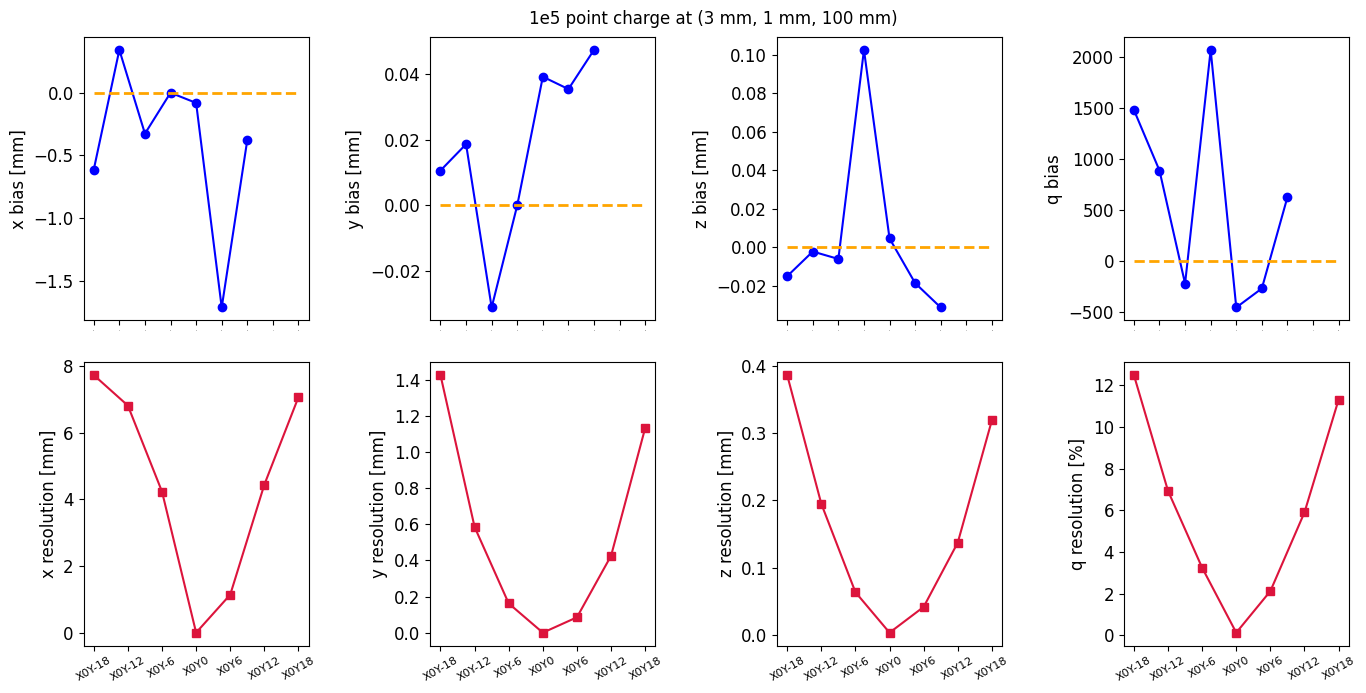

In [6]:
plot_histograms(fit_results)
plot_linecharts(fit_results)